### Measuring and characterizing fairness as a notion of inclusiveness.

Certain Machine Learning models are made to perform classification tasks of samples over labels which are subjective, what means that several users of the models might judge the label of the sample differently depending on their personal experience.

The predictions of the models might contain biases towards certain types of judgements which are more common than others and consequently easier to learn, and ignore other judgements. These biases might already be contained in the training dataset or generated by the classification model. 

However for the predictions to be fair towards each user of the model, they should be inclusive of all the different judgements, and possibly should be tuned to each of the users.

In this tutorial we teach:
- how to use metrics to measure how fair according to this notion of inclusiveness the models are,
- and how to use various characterizations of the predictions to understand where the unfairness might come from.

The tutorial is based on the example use-case of a Machine Learning model to classify the toxicity of a sentence (see image below).
We train a classifier (Logistic Regression) using the toxicity dataset (sentences and toxicity labels) to predict sentence toxicity, and evaluate how fair the outputs of the process are based on the ground truth annotations provided by multiple judges (crowdsourcing annotators).

![title](images/overview_tutorial_fairness_inclusiveness.png)

# Import statements

In [1]:
# Load all necessary packages
import sys
sys.path.append("../")  

import os

from aif360.datasets import ToxicityDataset
from aif360.metrics import InclusivenessLabelDatasetMetric

from IPython.display import Markdown, display

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import sklearn.metrics as sk_met
from sklearn.base import TransformerMixin, BaseEstimator

import numpy as np
import pickle
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import os

## Example to load the full toxicity dataset

In [2]:
from aif360.datasets import BinaryLabelDataset
import copy
### The toxicity dataset (toxicity_annotations.tsv, toxicity_annotated_comments.tsv, toxicity_worker_demographics.tsv) should be downloaded from https://figshare.com/articles/Wikipedia_Talk_Labels_Toxicity/4563973
### and placed in the folder "data/raw/toxicity".
# Example on how to load the full dataset.
#tox_dataset = ToxicityDataset()

## Train a model

### Load training and evaluation data

In [3]:
from nltk.tokenize import sent_tokenize, word_tokenize, regexp, RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

def clean_data(annotations, worker_demo, comments):
        
        # Preprocess workers.
        worker_demo = worker_demo.replace(np.NaN, 'nan')
 
        #### Add all the information to the annotations.
        # Add the worker demographics.
        annotations = annotations.reset_index().merge(worker_demo, on='worker_id', how='left').set_index(annotations.index.names)
        # Remove the unknown demographics and the demographics with a NaN. And put them in a general test set.
        annotations = annotations.replace(np.NaN, 'nan')
        annotations.loc[((annotations['english_first_language'].str.contains('nan')) |(annotations['gender'].str.contains('nan')) | (annotations['age_group'].str.contains('nan')) | (annotations['education'].str.contains('nan')) ),'general_split'] = 1 #'test'
        annotations = annotations.reset_index()
        annotations['english_first_language'] = annotations['english_first_language'].replace('nan', 2)
        annotations['pop_label'] = annotations[['gender', 'age_group', 'education']].apply(lambda x: ' '.join([str(x['gender']),str(x['age_group']), str(x['education'])]), axis=1)    
          
        # Add the comments in order to train / test the ML models.
        annotations = annotations.reset_index().merge(comments[['comment']].reset_index(), on='rev_id', how='left').set_index('index')
        return annotations
    
def normalize_text(text):
        tokenizer = RegexpTokenizer(r'\w+')
        stopword_set = set(stopwords.words('english'))
        stemmer = PorterStemmer()
        # Convert text to lower-case and strip punctuation/symbols from words.
        norm_text = text.lower()
        # Replace breaks with spaces.
        norm_text = norm_text.replace('<br />', ' ')
        # Pad punctuation with spaces on both sides.
        for char in ['.', '"', ',', '(', ')', '!', '?', ';', ':']:
            norm_text = norm_text.replace(char, ' ' + char + ' ') 
        # Tokenize.
        norm_text = tokenizer.tokenize(norm_text)
        # Remove stop words.
        norm_text = [w for w in norm_text if not w in stopword_set]
        norm_text = " ".join(norm_text)
        return norm_text

    
def clean_comments(comments):
        comments['comment'] = comments['comment'].apply(lambda x: x.replace("NEWLINE_TOKEN", " "))
        comments['comment'] = comments['comment'].apply(lambda x: x.replace("TAB_TOKEN", " "))
        comments['comment'] = comments['comment'].apply(lambda x: normalize_text(x))
        return comments

In [4]:
### Read the documents.    
try:
    print("Load the dataset.")
    filepath = os.path.join(os.path.dirname(os.path.abspath("__file__")), '..', 'aif360', 'data', 'raw', 'toxicity')
    print(filepath)
    comments = pd.read_csv(filepath + '/toxicity_annotated_comments.tsv', sep = '\t', dtype={'rev_id':int, 'comment':str}, index_col = 0)
    annotations = pd.read_csv(filepath + '/toxicity_annotations.tsv',  sep = '\t', index_col=0)
    worker_demo = pd.read_csv(filepath + '/toxicity_worker_demographics.tsv', sep='\t')
except IOError as err:
    print("IOError: {}".format(err))
    print("To use this class, please download the following files from https://figshare.com/articles/Wikipedia_Talk_Labels_Toxicity/4563973:")
    print("\n\ttoxicity_annotated_comments.tsv")
    print("\ttoxicity_annotations.tsv")
    print("\ttoxicity_worker_demographics.tsv")
    print("\nand place them, as-is, in the folder:")
    print("\n\t{}\n".format(os.path.abspath(os.path.join(os.path.abspath(__file__), '..', '..', 'data', 'raw', 'toxicity'))))
    import sys
    sys.exit(1)
    
### For now we do not use the whole dataset to be faster.
n_lim = 50000
comments = clean_comments(comments)
annotations = annotations.head(n_lim)
# Merge the different datasets.
annotations = clean_data(annotations, worker_demo, comments)
# Compute the ground truth (majority vote) label.
annotations['MV'] = annotations.groupby(['rev_id'])['toxicity'].transform(lambda x : (x.mean() >= 0.5).astype(int))

Load the dataset.
C:\Users\AgatheBalayn\Documents\thesis_related\AIF360\examples\..\aif360\data\raw\toxicity


c:\users\agathebalayn\documents\thesis_related\virtualenvs\aif306_v2\lib\site-packages\numpy\lib\arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [5]:
### Prepare the unique comments for training and testing of the ML models.
def prepare_aggregated_data(comment_):
    # Get the unique comments.
    comments = comment_.drop_duplicates('rev_id')
    # Cleaning.
    comments = comments[['comment', 'MV']]
    return comments

In [6]:
## Create the training and test sets.
from sklearn.model_selection import train_test_split
# Training and test sets with annotations as ground truth:
annotations_train, annotations_test = train_test_split(annotations, test_size=0.3)
# Training and test sets with majority-vote as ground truth:
comments_train = prepare_aggregated_data(annotations_train)
comments_test = prepare_aggregated_data(annotations_test)

In [7]:
# Functions to load the model.
class DataFrameColumnExtracter_doc(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X[self.column].values.astype('U')

In [8]:
### The ML model is then trained on the majority vote labels. 

## 1) Perform grid search over the parameters of the model.

# Load the model, here Logistic Regression model.
clf_LR = Pipeline([# Sentences.
                  ('sentences_features', Pipeline([
                      ('sentence_extractor', DataFrameColumnExtracter_doc('comment')),#.values.astype('U'),
                    ('vect', CountVectorizer(max_features = 1500, ngram_range = (1,5), analyzer = 'char')),
                     ('tf', TfidfTransformer(norm = 'l2'))
                  ])),
            # Classifier.
            ('clf', LogisticRegression())#C=LR_C, tol=LR_C_tol))
        ])

# Parameters of the grid search:
tuned_parameters = {'clf__C': [1e-4, 1e-2, 1, 10], 'clf__tol': [1, 1e-2, 1e-4]} 

# Initialize the grid search.
clf = GridSearchCV(clf_LR, tuned_parameters, cv=5, verbose=0)

# Functions to save and load the results of the grid search.
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
def load_obj(name ):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)
    
# Use a small number of data to train the model faster (this is used for quick testing).
nb_data = 5000

# Train the grid search.
# To comment if already run ones and the paramters were saved.
# =============
#best_model = clf.fit(dataset_train_comments[0:nb_data], dataset_train_comments['MV'][0:nb_data])
#best_parameters = best_model.best_params_  
#print(best_parameters)  
#best_result = best_model.best_score_  
#print(best_result)  
#save_obj(best_parameters, 'best_param_LR_aggregated')
# =============


## 2) Train the final model.
best_parameters = load_obj('best_param_LR_aggregated')
clf_LR.set_params(**best_parameters)
clf_LR.fit(comments_train[0:nb_data], comments_train['MV'][0:nb_data])


## 3) Evaluate general performance.
train_pred = clf_LR.predict(comments_train[0:nb_data])
test_pred = clf_LR.predict(comments_test[0:nb_data])
print("Training accuracy: ", sk_met.accuracy_score(comments_train['MV'][0:nb_data], train_pred))
print("Test accuracy: ", sk_met.accuracy_score(comments_test['MV'][0:nb_data], test_pred))

C_train = sk_met.confusion_matrix(comments_train['MV'][0:nb_data], train_pred)
C_train = C_train / C_train.astype(np.float).sum(axis=0)
C_test = sk_met.confusion_matrix(comments_test['MV'][0:nb_data], test_pred)
C_test = C_test / C_test.astype(np.float).sum(axis=0)
print("Training confusion matrix:", C_train)
print("Test confusion matrix:", C_test)

c:\users\agathebalayn\documents\thesis_related\virtualenvs\aif306_v2\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Training accuracy:  0.9597758655193116
Test accuracy:  0.9596607364501448
Training confusion matrix: [[0.95954357 0.03389831]
 [0.04045643 0.96610169]]
Test confusion matrix: [[0.95944206 0.03448276]
 [0.04055794 0.96551724]]


In [9]:
### Train a second ML model on the annotation (not majority-vote) labels in order to compare the fairness measures later. 

## 1) Perform grid search over the parameters of the model.

# Load the model, here Logistic Regression model.
clf_LR_annotations = Pipeline([# Sentences.
                  ('sentences_features', Pipeline([
                      ('sentence_extractor', DataFrameColumnExtracter_doc('comment')),#.values.astype('U'),
                    ('vect', CountVectorizer(max_features = 1500, ngram_range = (1,5), analyzer = 'char')),
                     ('tf', TfidfTransformer(norm = 'l2'))
                  ])),
            # Classifier.
            ('clf', LogisticRegression())#C=LR_C, tol=LR_C_tol))
        ])

# Parameters of the grid search:
tuned_parameters = {'clf__C': [1e-4, 1e-2, 1, 10], 'clf__tol': [1, 1e-2, 1e-4]} 

# Initialize the grid search.
clf_annotations = GridSearchCV(clf_LR_annotations, tuned_parameters, cv=5, verbose=0)
    
# Use a small number of data to train the model faster.
nb_data = 5000

# Train the grid search.
# To comment if already run ones and the paramters were saved.
# =============
#best_model = clf_annotations.fit(annotations_train[0:nb_data], annotations_train['toxicity'][0:nb_data])
#best_parameters = best_model.best_params_  
#print(best_parameters)  
#best_result = best_model.best_score_  
#print(best_result)  
#save_obj(best_parameters, 'best_param_LR_annotations')
# =============


## 2) Train the final model.
best_parameters = load_obj('best_param_LR_annotations')
clf_LR_annotations.set_params(**best_parameters)
clf_LR_annotations.fit(annotations_train[0:nb_data], annotations_train['toxicity'][0:nb_data])


## 3) Evaluate general performance.
train_pred = clf_LR_annotations.predict(annotations_train[0:nb_data])
test_pred = clf_LR_annotations.predict(annotations_test[0:nb_data])
print("Training accuracy: ", sk_met.accuracy_score(annotations_train['toxicity'][0:nb_data], train_pred))
print("Test accuracy: ", sk_met.accuracy_score(annotations_test['toxicity'][0:nb_data], test_pred))

C_train = sk_met.confusion_matrix(annotations_train['toxicity'][0:nb_data], train_pred)
C_train = C_train / C_train.astype(np.float).sum(axis=0)
C_test = sk_met.confusion_matrix(annotations_test['toxicity'][0:nb_data], test_pred)
C_test = C_test / C_test.astype(np.float).sum(axis=0)
print("Training confusion matrix:", C_train)
print("Test confusion matrix:", C_test)

Training accuracy:  0.92
Test accuracy:  0.9058
Training confusion matrix: [[0.92016632 0.08421053]
 [0.07983368 0.91578947]]
Test confusion matrix: [[0.91558038 0.37724551]
 [0.08441962 0.62275449]]


## Compute the fairness performance

In [10]:
from aif360.datasets import SubjectivityDataset

def default_preprocessing(df):
    return df

# Wrapper to load the datasets to compute the fairness on.
def subjectivity_dataset_wrapper(annotations, label_name,
                 protected_attribute_names=['gender', 'english_first_language', 'age_group', 'education', 'rev_id', 'worker_id', 'pop_label'], privileged_classes=None,
                 instance_weights_name=None, categorical_features=[],
                 features_to_keep=[], features_to_drop=[], na_values=[],
                 custom_preprocessing=default_preprocessing, 
                metadata={'label_maps': [{1.0: 'Toxic', 0.0: 'Non-toxic'}],},
                mapping_categorical_protected=(('gender',('female','male', 'other', 'nan')), ('age_group',('Under 18', '18-30', '30-45', '45-60', 'Over 60', 'nan')), ('education',('none', 'hs', 'some', 'bachelors', 'masters', 'professional', 'doctorate', 'nan')))):
    
    if 'comment' in annotations.columns.tolist():
        annotations = annotations.drop('comment', axis=1)
    if 'general_split' in annotations.columns.tolist():
        annotations = annotations.drop('general_split', axis=1)
          
    # Create the ground truth data
    if 'toxicity' in annotations.columns.tolist():
        annotations['GT'] = annotations['toxicity'].copy()
    if label_name != 'toxicity':
        # Delete the 'toxicity' column.
        if 'toxicity' in annotations.columns.tolist():
            annotations = annotations.drop('toxicity', axis=1)
        annotations.rename(columns={label_name:'toxicity'}, inplace=True)
        label_name = 'toxicity'
    else:
        if 'pred_1' in annotations.columns.tolist():
            annotations = annotations.drop('pred_1', axis=1)
    annotations = annotations.astype({"toxicity": float})

    # Make the categorical data numbers.
    if mapping_categorical_protected != ():
        for tuple_type in mapping_categorical_protected:
            for tuple_details in tuple_type:
                if tuple_type.index(tuple_details) == 0:
                    key = tuple_details
                else:
                    for tuple_categories in tuple_details:
                        annotations[key] = annotations[key].replace(tuple_categories, tuple_details.index(tuple_categories))

    annotations['pop_label'] = annotations[['gender', 'age_group', 'education']].apply(lambda x: int(''.join([str(x['gender']),str(x['age_group']), str(x['education'])])), axis=1)    
    annotations = annotations[['rev_id', 'worker_id', 'toxicity', 'toxicity_score', 'gender', 'english_first_language', 'age_group', 'education', 'pop_label', 'GT', 'MV']]
    
    dataset = SubjectivityDataset(annotations, label_name, 'GT',
                 protected_attribute_names=protected_attribute_names, privileged_classes=privileged_classes,
                 instance_weights_name=instance_weights_name, categorical_features=categorical_features,
                 features_to_keep=features_to_keep, features_to_drop=features_to_drop, na_values=na_values,
                 custom_preprocessing=custom_preprocessing, metadata=metadata)
    return dataset, annotations


# The dataset might be too large for the classifier to process all the data. In this case, it is splitted to get the predictions on all the data.
def compute_pred_dataset(classifier, dataset_orig_train, prediction_col, nb_data):
    for i in range(int(len(dataset_orig_train) / nb_data)):
        print(i)
        low_interval = i*nb_data
        high_interval = (i+1)*nb_data
        dataset_orig_train[prediction_col].iloc[low_interval:high_interval] = classifier.predict(dataset_orig_train.iloc[low_interval:high_interval])
    if high_interval < len(dataset_orig_train):
        dataset_orig_train[prediction_col].iloc[high_interval:] = classifier.predict(dataset_orig_train.iloc[high_interval:])
    return dataset_orig_train

In [11]:
### Create SubjectivityDataset datasets out of the training and test results and ground truth on the classifier trained on the MV.

prediction_col = "pred_1"
annotations_train[prediction_col] = -1
annotations_test[prediction_col] = -1
nb_data = 5000

subjectivity_dataset_test_GT, annotations_subjectivity_dataset_test_GT = subjectivity_dataset_wrapper(annotations_test, 'toxicity')
annotations_test_pred = compute_pred_dataset(clf_LR, annotations_test, prediction_col, nb_data)
subjectivity_dataset_test_outputs, annotations_subjectivity_dataset_test_outputs = subjectivity_dataset_wrapper(annotations_test_pred, prediction_col)

# Instantiate the fairness metric class.
test_metric_inclusion = InclusivenessLabelDatasetMetric(subjectivity_dataset_test_GT, subjectivity_dataset_test_outputs)

c:\users\agathebalayn\documents\thesis_related\virtualenvs\aif306_v2\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
c:\users\agathebalayn\documents\thesis_related\virtualenvs\aif306_v2\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


0


c:\users\agathebalayn\documents\thesis_related\virtualenvs\aif306_v2\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
c:\users\agathebalayn\documents\thesis_related\virtualenvs\aif306_v2\lib\site-packages\ipykernel_launcher.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


1
2


In [13]:
### Create SubjectivityDataset datasets out of the training and test results and ground truth on the classifier trained on the annotations.
annotations_test_pred_2 = compute_pred_dataset(clf_LR_annotations, annotations_test, prediction_col, nb_data)
subjectivity_dataset_test_outputs_2, annotations_subjectivity_dataset_test_outputs_2 = subjectivity_dataset_wrapper(annotations_test_pred, prediction_col)

# Instantiate the fairness metric class.
test_metric_inclusion_2 = InclusivenessLabelDatasetMetric(subjectivity_dataset_test_GT, subjectivity_dataset_test_outputs_2)

0


c:\users\agathebalayn\documents\thesis_related\virtualenvs\aif306_v2\lib\site-packages\ipykernel_launcher.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


1
2


In [14]:
results_test_annotator = test_metric_inclusion.compute_bin_metrics('annotator_disagreement', ('accuracy',), number_bins=None, filtering_value=None)
results_test_annotator_2 = test_metric_inclusion_2.compute_bin_metrics('annotator_disagreement', ('accuracy',), number_bins=None, filtering_value=None)

..\aif360\metrics\classification_metric.py:270: RuntimeWarning: invalid value encountered in double_scalars
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
..\aif360\metrics\classification_metric.py:271: RuntimeWarning: invalid value encountered in double_scalars
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,
..\aif360\metrics\inclusiveness_label_dataset_metric.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  bin_values[metric_to_compute] = list_bin_metric[eval_metrics.index(metric_to_compute)]
..\aif360\metrics\inclusiveness_label_dataset_metric.py:151: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  matrix_data = data.as_matrix([metric_to_compute])
..\aif360\metrics\classification_metric.py:270: Run

In [15]:
results_test_annotation = test_metric_inclusion.compute_bin_metrics('annotation_popularity', ('accuracy','TPR', 'TNR', 'FPR', 'FNR'), number_bins=None, filtering_value=None)
results_test_annotation_2 = test_metric_inclusion_2.compute_bin_metrics('annotation_popularity', ('accuracy','TPR', 'TNR', 'FPR', 'FNR'), number_bins=None, filtering_value=None)

..\aif360\metrics\inclusiveness_label_dataset_metric.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  bin_values[metric_to_compute] = list_bin_metric[eval_metrics.index(metric_to_compute)]
..\aif360\metrics\inclusiveness_label_dataset_metric.py:151: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  matrix_data = data.as_matrix([metric_to_compute])
..\aif360\metrics\inclusiveness_label_dataset_metric.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  bin_values[metric_to_compute] = list_bin_

In [16]:
results_test_demography = test_metric_inclusion.compute_bin_metrics('demography', ('accuracy', 'TPR'), number_bins=None, filtering_value=None)
results_test_demography_2 = test_metric_inclusion_2.compute_bin_metrics('demography', ('accuracy', 'TPR'), number_bins=None, filtering_value=None)

..\aif360\metrics\classification_metric.py:270: RuntimeWarning: invalid value encountered in double_scalars
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
..\aif360\metrics\classification_metric.py:271: RuntimeWarning: invalid value encountered in double_scalars
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,
..\aif360\metrics\inclusiveness_label_dataset_metric.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  bin_values[metric_to_compute] = list_bin_metric[eval_metrics.index(metric_to_compute)]


In [17]:
results_test_sample = test_metric_inclusion.compute_bin_metrics('sample_ambiguity', ('accuracy',), number_bins=None, filtering_value=None)
results_test_sample_2 = test_metric_inclusion_2.compute_bin_metrics('sample_ambiguity', ('accuracy',), number_bins=None, filtering_value=None)

..\aif360\metrics\classification_metric.py:270: RuntimeWarning: invalid value encountered in double_scalars
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
..\aif360\metrics\classification_metric.py:271: RuntimeWarning: invalid value encountered in double_scalars
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,
..\aif360\metrics\inclusiveness_label_dataset_metric.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  bin_values[metric_to_compute] = list_bin_metric[eval_metrics.index(metric_to_compute)]
..\aif360\metrics\inclusiveness_label_dataset_metric.py:151: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  matrix_data = data.as_matrix([metric_to_compute])
..\aif360\metrics\classification_metric.py:270: Run

In [18]:
print("Results: fairness on annotator")
print("Classifier with majority vote: ", results_test_annotator, " Classifier with annotations: ", results_test_annotator_2)
print("Results: fairness on samples")
print("Classifier with majority vote: ", results_test_sample, " Classifier with annotations: ", results_test_sample_2)
print("Results: fairness on annotations")
print("Classifier with majority vote: ", results_test_annotation, " Classifier with annotations: ", results_test_annotation_2)
print("Results: fairness on demographic categories")
print("Classifier with majority vote: ", results_test_demography, " Classifier with annotations: ", results_test_demography_2)

Results: fairness on annotator
Classifier with majority vote:  [(0.7889168587645954, 0.6254107586790191,                accuracy
bin_col                
(-0.001, 0.2]  0.945271
(0.2, 0.4]     0.761039
(0.4, 0.6]     0.621385
(0.6, 0.8]     0.391026
(0.8, 1.0]     0.408333)]  Classifier with annotations:  [(0.8170791879833249, 0.644303240019641,                accuracy
bin_col                
(-0.001, 0.2]  0.930994
(0.2, 0.4]     0.755707
(0.4, 0.6]     0.625841
(0.6, 0.8]     0.442308
(0.8, 1.0]     0.466667)]
Results: fairness on samples
Classifier with majority vote:  [(0.8361131831323065, 0.723516938309469,             accuracy
bin_col             
(0.5, 0.6]  0.510178
(0.6, 0.7]  0.596639
(0.7, 0.8]  0.714203
(0.8, 0.9]  0.822421
(0.9, 1.0]  0.974144)]  Classifier with annotations:  [(0.8421840080585414, 0.7105789078700903,             accuracy
bin_col             
(0.5, 0.6]  0.505886
(0.6, 0.7]  0.593838
(0.7, 0.8]  0.701896
(0.8, 0.9]  0.790675
(0.9, 1.0]  0.960601)]
Results: f

In [19]:
def translate_demography_index(data):
    for index, row in data.iterrows():
        print(index)
        print(str(int(index)))
        demog_translation = ''
         
        # Find the fist element (gender)
        if len(str(int(index))) < 3:
            # This means the gender is 0.
            demog_translation += 'female'
        else:
            if str(int(index))[0] == '1':
                demog_translation += 'male'
            elif str(int(index))[0] == '2':
                demog_translation += 'other'
            elif str(int(index))[0] == '3':
                demog_translation += 'nan'
        # Find the second element:
        demog_translation += ' '
        if len(str(int(index))) < 2:
            # This means the gender and age is 0.
            demog_translation += 'Under 18'
        else:
            if str(int(index))[1] == '1':
                demog_translation += '18-30'
            elif str(int(index))[1] == '2':
                demog_translation += '30-45'
            elif str(int(index))[1] == '3':
                demog_translation += '45-60'
            elif str(int(index))[1] == '4':
                demog_translation += 'Over 60'
            elif str(int(index))[1] == '5':
                demog_translation += 'nan'
    
        # Find the third element:
        demog_translation += ' '
        index_element = len(str(int(index))) - 1
        
        if str(int(index))[index_element] == '0':
            demog_translation += 'none'
        elif str(int(index))[index_element] == '1':
            demog_translation += 'hs'
        elif str(int(index))[index_element] == '2':
            demog_translation += 'some'
        elif str(int(index))[index_element] == '3':
            demog_translation += 'bachelors'
        elif str(int(index))[index_element] == '4':
            demog_translation += 'masters'
        elif str(int(index))[index_element] == '5':
            demog_translation += 'professional'
        elif str(int(index))[index_element] == '6':
            demog_translation += 'doctorate'
        elif str(int(index))[index_element] == '7':
            demog_translation += 'nan'
        data.rename(index={index:demog_translation}, inplace=True)
    return data

In [20]:
translate_demography_index(results_test_demography[0][2])

111.0
111
123.0
123
35.0
35
23.0
23
11.0
11
121.0
121
21.0
21
113.0
113
357.0
357
14.0
14
31.0
31
115.0
115
153.0
153
114.0
114
124.0
124
125.0
125
13.0
13
131.0
131
134.0
134
112.0
112
151.0
151
135.0
135
101.0
101
53.0
53
15.0
15
32.0
32
1.0
1
34.0
34
25.0
25
24.0
24
133.0
133
103.0
103
154.0
154
12.0
12
22.0
22
51.0
51
126.0
126
33.0
33
122.0
122
42.0
42
54.0
54
26.0
26
44.0
44
143.0
143
16.0
16
145.0
145
116.0
116
132.0
132
43.0
43
3.0
3
104.0
104
2.0
2
45.0
45
46.0
46
102.0
102
136.0
136
155.0
155
41.0
41
201.0
201
152.0
152
52.0
52
110.0
110
56.0
56
36.0
36


,accuracy
pop_label,
male 18-30 hs,0.922283
male 30-45 bachelors,0.909445
female nan professional,0.840000
female 45-60 bachelors,0.907975
female 18-30 hs,0.916667
male 30-45 hs,0.927914
female 18-30 hs,0.923077
male 18-30 bachelors,0.932124
nan nan nan,0.924088


In [21]:
def annotation_plot_color(value):
    if value > 0.5:
        return 'b'
    else:
        return 'w'

def plot_fairness(data, metric, bin_name='', title_name=''):
    yticks = list(data.index.values)

    # Plot the bins
    data = data.as_matrix(columns=[metric])
    fig, ax = plt.subplots()
    heatmap = ax.pcolor(data)
    cbar = fig.colorbar(heatmap, ax=ax)
    cbar.set_label(metric, rotation=90)

    ax.set_yticks(np.arange(data.shape[0]) + 0.5, minor=False)
    ax.set_yticklabels(yticks,rotation=0)
    ax.set_ylabel(bin_name)
    ax.tick_params(left='off', bottom='off',labelbottom='off', color='grey',labelsize='small')

    # Add the exact evaluation measure per bin
    for i in range(data.shape[0]):
        text = ax.text(0.5, i+0.5, np.round(data[i][0], 2), ha="center", va="center", color=annotation_plot_color(data[i][0]))
    if title_name != '':
        ax.set_title(title_name)
    fig.set_figwidth(4)
    fig.show()

c:\users\agathebalayn\documents\thesis_related\virtualenvs\aif306_v2\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()
c:\users\agathebalayn\documents\thesis_related\virtualenvs\aif306_v2\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
c:\users\agathebalayn\documents\thesis_related\virtualenvs\aif306_v2\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


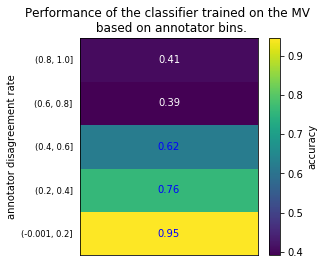

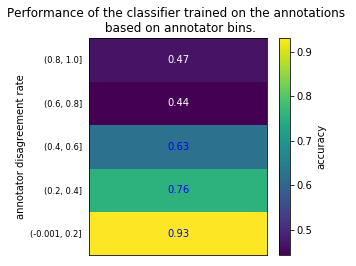

In [22]:
# Example visualisation of the results: comparison of the performance of the two classifiers on the different fairness-bins.
plot_fairness(results_test_annotator[0][2], 'accuracy', 'annotator disagreement rate', 'Performance of the classifier trained on the MV \n based on annotator bins.')
plot_fairness(results_test_annotator_2[0][2], 'accuracy', 'annotator disagreement rate', 'Performance of the classifier trained on the annotations \n based on annotator bins.')
# We observe that although the second classifier performs less well for the annotators who often agree with the majority (bin [0.001; 0.2]), it performs better for the annotators who disagree a lot with the majority vote (bin [0.8; 1.0]), what makes it globally fairer.